In [2]:
import sys
sys.path.append("../")

In [3]:
%load_ext autoreload
%autoreload 2

import src.ksd.models as models
from src.ksd.find_modes import find_modes, pairwise_directions, run_bfgs
from src.ksd.langevin import RandomWalkMH, RandomWalkBarker
import src.ksd.langevin as mcmc
from src.ksd.ksd import KSD
from src.ksd.kernel import IMQ, RBF
from src.ksd.bootstrap import Bootstrap
from src.ksd.find_modes import find_modes, pairwise_directions
from tqdm.notebook import tqdm, trange

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns

import src.kgof.density as density
import src.kgof.data as data

MCMCKernel = RandomWalkMH # RandomWalkBarker

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
tf.random.set_seed(1)

DELTA = 2.

In [3]:
# # normal
# def generate_target_proposal(dim, delta=DELTA):
#     # single gaussians
    
#     mean1 = tf.eye(dim)[:, 0] * delta
#     mean2 = tf.zeros(dim)

#     target = tfd.MultivariateNormalDiag(mean1)
#     proposal_off = tfd.MultivariateNormalDiag(mean2)
    
#     return target, proposal_off

In [4]:
# # laplace
# def generate_target_proposal(dim, delta=DELTA):
#     # single gaussians
    
#     mean1 = tf.eye(dim)[:, 0] * delta
#     mean2 = tf.zeros(dim)

#     target = tfd.Laplace(mean1, scale=1.)
#     proposal_off = tfd.Laplace(mean2, scale=1.)
    
#     return target, proposal_off

In [5]:
# t
def generate_target_proposal(dim, delta=DELTA):
    # single gaussians
    
    mean1 = tf.eye(dim)[:, 0] * delta
    mean2 = tf.zeros(dim)

    target = tfd.StudentT(df=5, loc=mean1, scale=1.)
    proposal_off = tfd.StudentT(df=5, loc=mean2, scale=1.)
    
    return target, proposal_off

2023-01-17 10:47:04.248781: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-17 10:47:04.248830: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: nvidia4
2023-01-17 10:47:04.248835: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: nvidia4
2023-01-17 10:47:04.248944: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.27.4
2023-01-17 10:47:04.248965: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.27.4
2023-01-17 10:47:04.248969: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.27.4
2023-01-17 10:47:04.249615: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

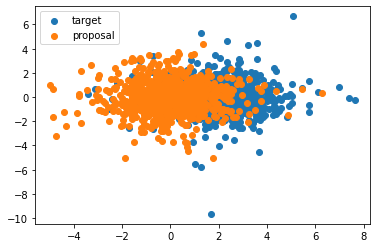

In [6]:
target, proposal = generate_target_proposal(2)
target_x = target.sample(1000)
proposal_x = proposal.sample(1000)

fig, ax = plt.subplots()
ax.scatter(target_x[:, 0], target_x[:, 1], label="target")
ax.scatter(proposal_x[:, 0], proposal_x[:, 1], label="proposal")
ax.legend()
plt.show()

In [7]:
def plot_bandwidth(dims, kernel_class, n):
    
    bandwidths = []
    for d in dims:
        print(f"dim {d}")
        _, proposal_dist = generate_target_proposal(d)
        X = proposal_dist.sample(n)
        
        kernel = kernel_class(med_heuristic=True)
        kernel.bandwidth(X, tf.identity(X))
        bandwidths.append(kernel.sigma_sq)
        
    # plot
    fig, ax = plt.subplots()
    ax.plot(dims, bandwidths, label="empirical")
    ax.plot(dims, 2 * np.array(dims), label="theoretical")
    ax.set_ylabel("Bandwidth")
    ax.set_xlabel("Dim")
    ax.legend()
    plt.show()
    
    return bandwidths

In [8]:
dims = [1, 2, 5, 10, 20, 30, 40, 50, 100]

dim 1
dim 2
dim 5
dim 10
dim 20
dim 30
dim 40
dim 50
dim 100


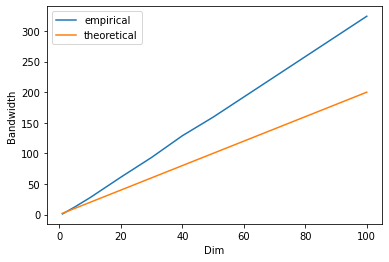

In [9]:
tf.random.set_seed(1)
bandwidths = plot_bandwidth(dims, RBF, n=1000)

In [10]:
def ksd_gaussians(d, bandwidth=None, delta=DELTA):
    if not bandwidth:
        bandwidth = 2 * d
    lmda = bandwidth / 2.
    
    mean1 = tf.eye(d)[:, 0] * delta
    mean1_norm_sq = np.sum(mean1**2)
    
    res = (lmda / (lmda + 2))**(d/2) * mean1_norm_sq

    return res

def h1_var_gaussians(d, bandwidth_order, bandwidth=None, delta=DELTA):
    if not bandwidth:
        bandwidth = 2 * d
    lmda = bandwidth / 2.
    
    mean1 = tf.eye(d)[:, 0] * delta
    mean1_norm_sq = np.sum(mean1**2)

#     if bandwidth_order > 1.:
#         res = 4 * mean1_norm_sq
#     elif bandwidth_order == 1.:
#         lmda = bandwidth / 2.
#         res = 4 * np.exp(-d/lmda - d/(lmda + 3.)) * mean1_norm_sq
        
    # analytical form
    var_exp_up = (lmda / (lmda + 1))**(d/2) * (lmda / (lmda + 2))**(d/2) * (
        (lmda + 2) / (lmda + 1) * mean1_norm_sq + mean1_norm_sq**2
    )
    res = var_exp_up - ksd_gaussians(
        d=d, bandwidth=bandwidth, delta=delta
    )**2
    
    return res

def up_moments_gaussians(d, bandwidth_order, bandwidth=None):
    if not bandwidth:
        bandwidth = 2 * d
    
    lmda = bandwidth / 2.
    if bandwidth_order == 1.:
        res = np.exp(-2*d / lmda) * (d + d**2 / (lmda + 4))
    else:
        res = -1. # placeholder
        
    return res

def up_sq_gaussians(d, bandwidth_order, bandwidth=None, delta=DELTA):
    lmda = bandwidth / 2.
    
    mean1 = tf.eye(d)[:, 0] * delta
    mean1_norm_sq = np.sum(mean1**2)

    res = (lmda / (lmda + 4))**(d/2) * (
#         -4 * d**2 / lmda + d + d * mean1_norm_sq + mean1_norm_sq**2
#         24 * d**2 / lmda**2 + d + 5 * d * mean1_norm_sq / lmda + mean1_norm_sq**2
        7 * d**2 / lmda + d + 6 * d / lmda * mean1_norm_sq + 2 * mean1_norm_sq + mean1_norm_sq**2
    )
    return res
    

In [11]:
def compute_ksd(dims, deltas, kernel_class, n, bandwidth_order, verbose=False):
    
    dims_output = []
    deltas_output = []

    ksd_empirical_list = []
    ksd_theoretical_list = []
    h1_var_empirical_list = []
    h1_var_theoretical_list = []
    m2_empirical_list = []
    m3_empirical_list = []
    M2_empirical_list = []
    
    bandwidth_list = []
    for d in dims:
        for delta in deltas:
            if verbose:
                print(f"dim: {d}; delta: {delta}")
        
            dims_output.append(d)
            deltas_output.append(delta)
            
            target, proposal_dist = generate_target_proposal(d, delta)
            X = proposal_dist.sample(n)

            # compute ksd empirically and theoretically
            kernel = kernel_class(sigma_sq=2.*d**bandwidth_order)

            ksd = KSD(kernel=kernel, log_prob=target.log_prob)
            ksd_val = ksd(X, tf.identity(X))
            ksd_empirical_list.append(ksd_val)

            ksd_theoretical_list.append(
                ksd_gaussians(d, bandwidth=kernel.sigma_sq, delta=delta)
            )

            # compute ksd empirically and theoretically
            h1_var = ksd.h1_var(X=X, Y=tf.identity(X))
            h1_var_empirical_list.append(h1_var)

            h1_var_theoretical_list.append(
                h1_var_gaussians(d, bandwidth=kernel.sigma_sq, bandwidth_order=bandwidth_order, delta=delta)
            )

            # store bandwidths
            bandwidth_list.append(kernel.sigma_sq)

            # abs central cond moments
            m2_empirical_list.append(ksd.abs_cond_central_moment(X, tf.identity(X), k=2))
            m3_empirical_list.append(ksd.abs_cond_central_moment(X, tf.identity(X), k=3))
            
            # abs central full moments
            M2_empirical_list.append(ksd.abs_full_central_moment(X, tf.identity(X), k=2))

#             # store E[u_p^2]
#             moment2_empirical_list.append(ksd.u_p_moment(X, tf.identity(X), k=2))

#             moment2_theoretical_list.append(
#                 up_sq_gaussians(d, bandwidth=kernel.sigma_sq, bandwidth_order=bandwidth_order, delta=delta)
#             )

    res = pd.DataFrame({
        "dim": np.array(dims_output),
        "delta": np.array(deltas_output),
        "bandwidth": bandwidth_list,
        "ksd_empirical": np.array(ksd_empirical_list),
        "ksd_theoretical": np.array(ksd_theoretical_list),
        "h1_var_empirical": np.array(h1_var_empirical_list),
        "h1_var_theoretical": np.array(h1_var_theoretical_list),
#         "moment2_empirical": np.array(moment2_empirical_list),
#         "moment2_theoretical": np.array(moment2_theoretical_list),
        "m2_empirical": np.array(m2_empirical_list),
        "m3_empirical": np.array(m3_empirical_list),
        "M2_empirical": np.array(M2_empirical_list),
    })
    
    return res


def repeat_compute_ksd(dims, deltas, kernel_class, n, nreps, bandwidth_order, verbose=False):
    res_list = []
    
    for i in range(nreps):
        print(f"[{i+1} / {nreps}]")
        res = compute_ksd(dims, deltas, kernel_class, n, bandwidth_order, verbose)
        res["seed"] = i
        res_list.append(res)
        
    res = pd.concat(res_list, axis=0)
    return res

In [16]:
def plot_ksd(res, figsize, plot_theoretical=True):
    dims = res["dim"]
    
    figs, axes = plt.subplots(figsize=figsize, nrows=1, ncols=3)
    axes[0].plot(dims, res["ksd_empirical"], marker="o", label="empirical")
    axes[0].set_ylabel("KSD")
    axes[0].set_xlabel("Dim")
    axes[0].legend()
    
    axes[1].plot(dims, res["h1_var_empirical"], marker="o", label="empirical")
    axes[1].set_ylabel("h1_var")
    axes[1].set_xlabel("Dim")
    axes[1].legend()
    
    axes[2].plot(dims, res["ksd_empirical"] / np.sqrt(res["h1_var_empirical"]), marker="o", label="empirical")
    axes[2].set_ylabel("KSD / sqrt(h1_var)")
    axes[2].set_xlabel("Dim")
    axes[2].legend()

    if plot_theoretical:
        axes[0].plot(dims, res["ksd_theoretical"], marker="x", label="theoretical")
        axes[1].plot(dims, res["h1_var_theoretical"], marker="x", label="theoretical")
        axes[2].plot(dims, res["ksd_theoretical"] / np.sqrt(res["h1_var_theoretical"]), marker="x", label="theoretical")

    plt.tight_layout()
    
def plot_moments(res, figsize):
    dims = res["dim"]
    
    figs, axes = plt.subplots(figsize=figsize, nrows=1, ncols=4)
    axes[0].plot(dims, res["ksd_empirical"], marker="o", label="empirical")
    axes[0].set_ylabel("KSD")
    axes[0].set_xlabel("Dim")
    axes[0].set_ylim(bottom=0)
    axes[0].legend()
    
    axes[1].plot(dims, res["m2_empirical"], marker="o", label="empirical")
    axes[1].set_ylabel("m2")
    axes[1].set_xlabel("Dim")
    axes[1].set_ylim(bottom=0)
    axes[1].legend()
    
    axes[2].plot(dims, res["m3_empirical"] / np.sqrt(res["h1_var_empirical"]), marker="o", label="empirical")
    axes[2].set_ylabel("m3")
    axes[2].set_xlabel("Dim")
    axes[2].set_ylim(bottom=0)
    axes[2].legend()

    axes[3].plot(dims, res["M2_empirical"] / np.sqrt(res["h1_var_empirical"]), marker="o", label="empirical")
    axes[3].set_ylabel("M2")
    axes[3].set_xlabel("Dim")
    axes[3].set_ylim(bottom=0)
    axes[3].legend()

    plt.tight_layout()

In [13]:
tf.random.set_seed(2022)
# dims = [1, 2, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500,]
dims = [1, 5, 20, 40, 50, 100, 200, 300]
deltas = [2.]

# res = repeat_compute_ksd(dims, deltas, RBF, n=4000, nreps=1, bandwidth_order=1., verbose=True)
# res = repeat_compute_ksd(dims, deltas, RBF, n=4000, nreps=1, bandwidth_order=0., verbose=True)
res = repeat_compute_ksd(dims, deltas, IMQ, n=4000, nreps=1, bandwidth_order=1., verbose=True)
# res_over = repeat_compute_ksd(dims, deltas, RBF, n=4000, nreps=1, bandwidth_order=5., verbose=True)

[1 / 1]
dim: 1; delta: 2.0
dim: 5; delta: 2.0
dim: 20; delta: 2.0
dim: 40; delta: 2.0
dim: 50; delta: 2.0
dim: 100; delta: 2.0
dim: 200; delta: 2.0
dim: 300; delta: 2.0


In [14]:
# # fixed dim, different deltas
# tf.random.set_seed(2022)
# dims = [20]
# deltas = [2., 4., 8., 16., 32., 64., 128.]

# res_delta = repeat_compute_ksd(dims, deltas, RBF, n=4000, nreps=1, bandwidth_order=1., verbose=True)

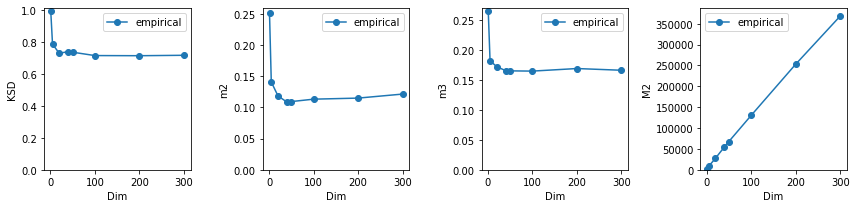

In [17]:
# bandwidth = 2d
plot_moments(res, figsize=(12, 3))

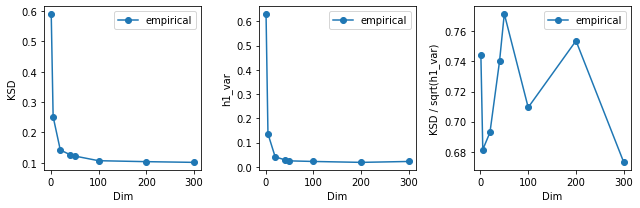

In [30]:
# bandwidth = 2d
plot_ksd(res, figsize=(9, 3), plot_theoretical=False)

In [28]:
# bandwidth = 2d^r, r > 1
# res_over = repeat_compute_ksd(dims, RBF, n=2000, nreps=1, bandwidth_order=2.)
plot_ksd(res_over, figsize=(9, 3))

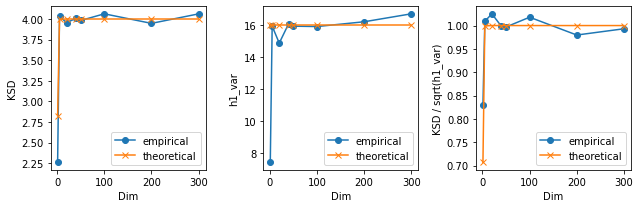

In [21]:
# with new (possibly wrong) form of KSD
plot_ksd(res_over, figsize=(9, 3))

# $E[\|x\|^2 (\mu^\intercal x)^r]$, $r=1, 2, 3, 4$

In [92]:
def norm2_mu_x(r, mu):
    dim = mu.shape[-1]
    
    if r % 2 == 1:
        res = 0.
        
    elif r == 2:
        res = (dim + 2) * tf.reduce_sum(mu**2)
    
    elif r == 4:
        res = (6*dim + 24) * tf.reduce_sum(mu**2)**4 - (3*dim + 12) * tf.reduce_sum(mu**4)
    return res

In [95]:
tf.random.set_seed(1)

r = 2
dims = [10, 25, 50, 75, 100, 250, 500, 1000]
n = 10000
nrep = 50

res_numerical_rep = []
res_theoretical_rep = []

for i in range(nrep):
    if i % 5 == 0:
        print(f"[{i+1} / {nrep}]")

    res_numerical = []
    res_theoretical = []

    for dim in dims:
        mu = tf.eye(dim)[:1] # 1 x dim
        x = tf.random.normal((n, dim))

        dnorm2 = tf.reduce_sum(x**2, axis=1) # n
        inner_prod = tf.linalg.matmul(x, mu, transpose_b=True) # n x 1
        res = tf.reduce_mean(dnorm2 * inner_prod**r)
        res_numerical.append(res)

        res_theoretical.append(norm2_mu_x(r, mu))
        
    res_numerical_rep.append(res_numerical)
    res_theoretical_rep.append(res_theoretical)

[1 / 50]
[6 / 50]
[11 / 50]
[16 / 50]
[21 / 50]
[26 / 50]
[31 / 50]
[36 / 50]
[41 / 50]
[46 / 50]


In [49]:
3 % 2

1

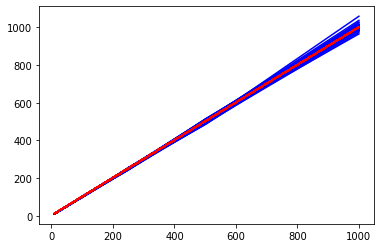

In [96]:
x_vals = np.array([dims]*nrep).T
y_vals_num = np.array(res_numerical_rep).T
y_vals_the = np.array(res_theoretical_rep).T

_ = plt.plot(x_vals, y_vals_num, label="numerical", color="blue")
_ = plt.plot(x_vals, y_vals_the, label="theoretical", color="red")
# plt.plot([dims[0], dims[-1]], [res_numerical[0], res_numerical[-1]], label="ref")
# plt.legend()